In [1]:
import cv2
import numpy as np
import PIL
from math import pi
import math
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import skimage.io
from scipy import ndimage as ndi
from statistics import mean

print("Done")

Done


In [2]:
def do_image(original, R, G, B, alpha_chan = [], thresh_lo = 1, thresh_hi = 254, erode_val = 10, gauss_val = 9, exponent = 0.18, gauss_val2 = 3):
    # original = cv2.cvtColor(cv2.imread("download.png"), cv2.COLOR_BGR2RGB)
    r_channel, g_channel, b_channel = cv2.split(original)
    color_channels = [r_channel, g_channel, b_channel]
    border_int = 3
    if len(alpha_chan) == 0:
        img = cv2.copyMakeBorder(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), border_int, border_int, border_int, border_int, cv2.BORDER_CONSTANT, value=255)    
        ret, thresh = cv2.threshold(img, thresh_lo, thresh_hi, cv2.THRESH_BINARY)
    else:        
        img = cv2.copyMakeBorder(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), border_int, border_int, border_int, border_int, cv2.BORDER_CONSTANT, value=255)    
        alpha_chan = cv2.copyMakeBorder(cv2.cvtColor(alpha_chan, cv2.COLOR_BGR2GRAY), border_int, border_int, border_int, border_int, cv2.BORDER_CONSTANT, value=255)
        ret, thresh = cv2.threshold(alpha_chan, thresh_lo, thresh_hi, cv2.THRESH_BINARY)
        
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    dist = cv2.GaussianBlur(dist, (gauss_val, gauss_val), 0)
    dist = dist[border_int:img.shape[0]-border_int, border_int:img.shape[1]-border_int]
    norm_dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    new_alpha_channel = cv2.bitwise_not((255 * norm_dist).astype(b_channel.dtype))
    kernel = np.ones((erode_val, erode_val), np.uint8)
    new_alpha_channel = cv2.erode(new_alpha_channel, kernel)
    img_BGRA = cv2.merge((r_channel, g_channel, b_channel, new_alpha_channel))
    
    return img_BGRA, new_alpha_channel

def weight_func(imageA, imageB):
    # the 'Mean Squared Error' between the two alpha channels is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

print("Done")

Done


Target:


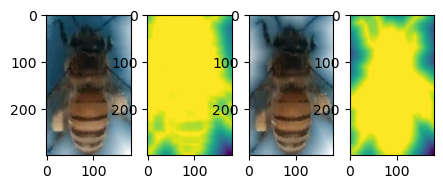

Starting sum: 1424


Monte Carlo Param Search::   0%|               | 14/1500000 [00:00<41:16, 605.73iteration/s, Best=1.42e+3, Sum=2.47e+3]

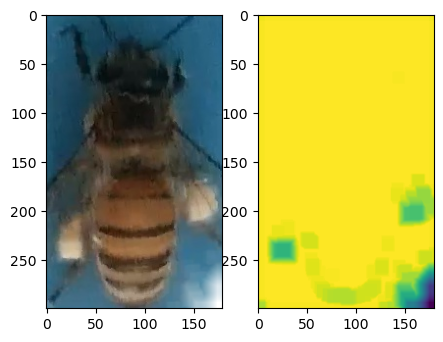

Monte Carlo Param Search::   0%|              | 18/1500000 [00:00<5:01:42, 82.86iteration/s, Best=1.18e+3, Sum=2.03e+3]

[55, 84, 180, [], 120, 197, 12, 3, 2.336, 3]


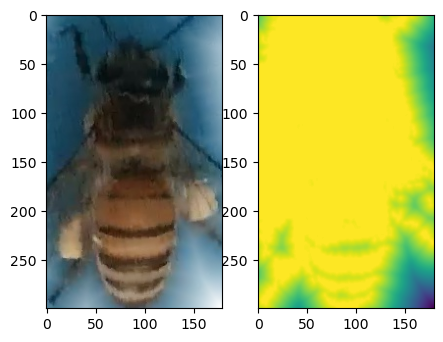

Monte Carlo Param Search::   0%|                  | 31/1500000 [00:00<6:12:26, 67.12iteration/s, Best=102, Sum=2.06e+3]

[191, 203, 127, [], 92, 234, 2, 3, 8.242, 1]


Monte Carlo Param Search::   0%|                  | 40/1500000 [00:00<6:12:26, 67.12iteration/s, Best=102, Sum=1.05e+4]

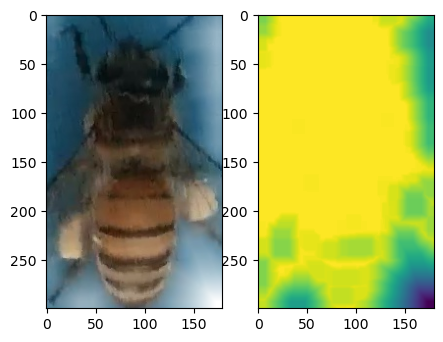

Monte Carlo Param Search::   0%|               | 148/1500000 [00:00<1:50:11, 226.87iteration/s, Best=28.4, Sum=8.75e+3]

[253, 51, 188, [], 95, 107, 14, 3, 7.772, 5]


Monte Carlo Param Search::   0%|               | 169/1500000 [00:00<1:18:52, 316.91iteration/s, Best=28.4, Sum=2.03e+3]

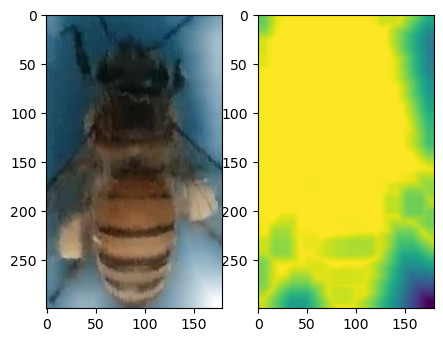

Monte Carlo Param Search::   0%|               | 285/1500000 [00:01<1:12:39, 344.03iteration/s, Best=15.4, Sum=1.35e+4]

[53, 106, 57, [], 93, 148, 13, 9, 2.531, 7]


Monte Carlo Param Search::   0%|                  | 362/1500000 [00:01<59:53, 417.30iteration/s, Best=15.4, Sum=4.6e+3]

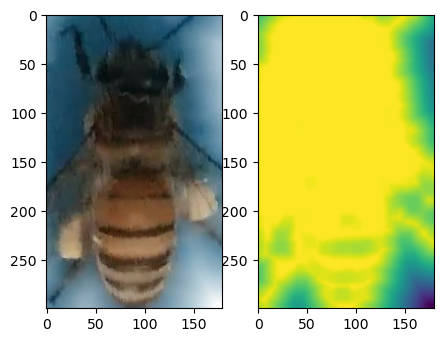

Monte Carlo Param Search::   0%|               | 418/1500000 [00:01<1:16:09, 328.18iteration/s, Best=10.9, Sum=2.88e+3]

[3, 205, 216, [], 89, 137, 7, 9, 9.301, 9]


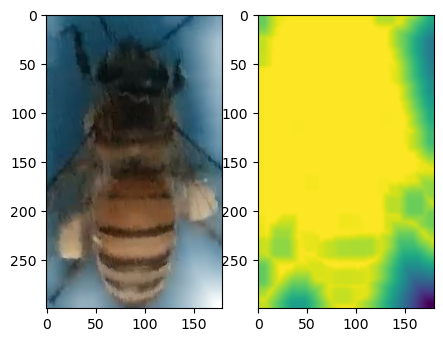

Monte Carlo Param Search::   0%|                | 539/1500000 [00:01<1:11:24, 349.94iteration/s, Best=6.21, Sum=3.2e+3]

[46, 65, 37, [], 92, 139, 12, 7, 0.262, 7]


Monte Carlo Param Search::   0%|                 | 606/1500000 [00:01<58:52, 424.43iteration/s, Best=6.21, Sum=2.69e+3]

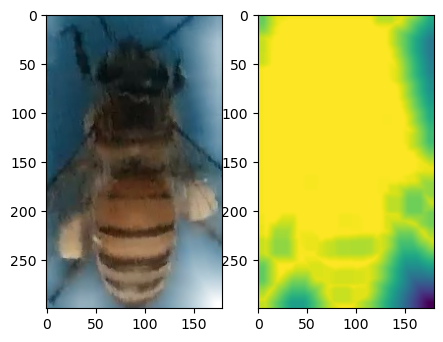

Monte Carlo Param Search::   0%|                  | 725/1500000 [00:02<1:00:27, 413.36iteration/s, Best=4.53, Sum=2e+3]

[139, 251, 175, [], 92, 93, 11, 9, 5.037, 1]


Monte Carlo Param Search::   0%|                    | 2795/1500000 [00:05<36:54, 676.09iteration/s, Best=4.53, Sum=415]

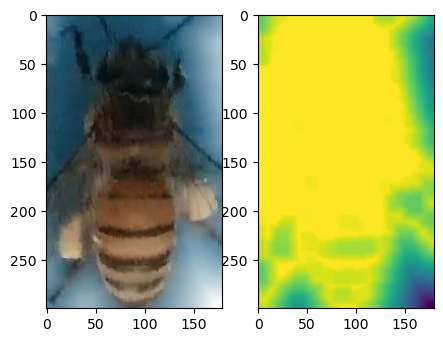

Monte Carlo Param Search::   0%|                    | 2820/1500000 [00:05<36:54, 676.09iteration/s, Best=3.79, Sum=790]

[128, 233, 128, [], 91, 142, 10, 3, 6.624, 9]


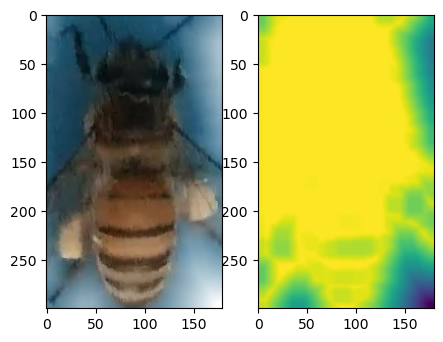

Monte Carlo Param Search::   0%|             | 2938/1500000 [00:05<1:00:20, 413.55iteration/s, Best=0.596, Sum=1.82e+3]

[87, 87, 197, [], 92, 102, 10, 9, 1.096, 9]


Monte Carlo Param Search::   0%|                | 4260/1500000 [00:07<39:10, 636.26iteration/s, Best=0.596, Sum=7.8e+3]

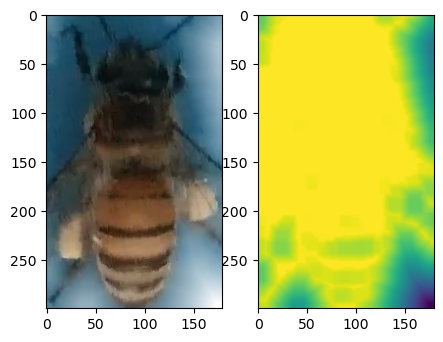

Monte Carlo Param Search::   0%|                   | 4374/1500000 [00:08<51:46, 481.46iteration/s, Best=0.196, Sum=812]

[255, 100, 8, [], 92, 103, 10, 3, 6.306, 3]


Monte Carlo Param Search::   3%|▍             | 50183/1500000 [01:24<41:22, 583.95iteration/s, Best=0.196, Sum=2.09e+3]

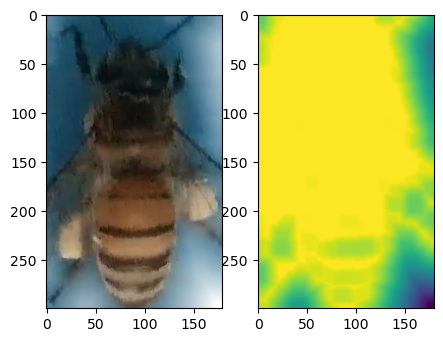

Monte Carlo Param Search::   3%|▌                 | 50293/1500000 [01:24<58:09, 415.43iteration/s, Best=0, Sum=2.15e+3]

[43, 206, 188, [], 92, 108, 10, 5, 5.759, 9]


Monte Carlo Param Search::   4%|▋                 | 58362/1500000 [01:38<39:35, 606.85iteration/s, Best=0, Sum=4.58e+3]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Monte Carlo Param Search::  17%|███               | 250976/1500000 [06:44<35:44, 582.30iteration/s, Best=0, Sum=3.4e+3]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Monte Carlo Param Search::  27%|████▋            | 411923/1500000 [11:04<32:01, 566.12iteration/s, Best=0, Sum=6.01e+3]

In [ ]:
reference_img = cv2.cvtColor(cv2.imread("blue_reference_img.png"), cv2.COLOR_BGR2RGB)
# _, img2 = cv2.threshold(cv2.cvtColor(cv2.imread("new_download.png"), cv2.COLOR_BGR2GRAY), 1, 254, cv2.THRESH_BINARY) #this is without manipulation (hard-lined reference alpha)
reference_alpha = cv2.bitwise_not(cv2.imread("blue_reference_alpha.png")) # this manipulates the reference alpha (soft lined)

starting_params = [79, 181, 79, [], 92, 114, 10, 5, 0.09, 1]

img1, alpha1 = do_image(reference_img, *starting_params)
# reference image w/ reference alpha
img2, alpha2 = do_image(reference_img,
                        starting_params[0],
                        starting_params[1],
                        starting_params[2],
                        alpha_chan = reference_alpha,
                        thresh_lo = starting_params[4],
                        thresh_hi = starting_params[5],
                        erode_val = starting_params[6],
                        gauss_val = starting_params[7],
                        exponent = starting_params[8],
                        gauss_val2 = starting_params[9]
                       )
print("Target:")
fig, axs = plt.subplots(ncols = 2, figsize=(5, 5))
axs[0].imshow(img2)
axs[1].imshow(alpha2)
for ax in axs:
    plt.show()
start_running_sum = weight_func(alpha1, alpha2)
print("Starting sum: %d" % (start_running_sum))
best_params = starting_params
best_sum = start_running_sum

k = 0
iters = 1500000
with tqdm(total=iters, unit="iteration", desc=str("Monte Carlo Param Search:")) as pbar:
    while k < iters:
        thresh_hi = random.randint(1,255) # default == 255
        thresh_lo = random.randint(0, thresh_hi) # default == 0
        erode_val = random.randint(0, 30) # default == 3
        gauss_val = random.choice([1, 3, 5, 7, 9])
        exponent = random.randint(10, 10000) / 1000
        gauss_val2 = random.choice([1, 3, 5, 7, 9])
        R = random.randint(0, 255)
        G = random.randint(0, 255)
        B = random.randint(0, 255)
        new_params = [R, G, B, [], thresh_lo, thresh_hi, erode_val, gauss_val, exponent, gauss_val2]
        img3, markers = do_image(reference_img, *new_params)
        new_running_sum = weight_func(markers, alpha2)
        if new_running_sum < best_sum:
            best_sum = new_running_sum
            best_params = new_params
            fig, axs = plt.subplots(ncols = 2, figsize=(5, 5))
            axs[0].imshow(img3)
            axs[1].imshow(markers)
            for ax in axs:
                plt.show()
            print(best_params)
        k = k + 1
        pbar.set_postfix(Sum = new_running_sum, Best = best_sum, refresh=True)
        pbar.update(1)

new_img, new_alpha = do_image(reference_img, *best_params)
fig, axs = plt.subplots(ncols = 4, figsize=(15, 15))
axs[0].imshow(reference_img)
axs[1].imshow(reference_alpha)
axs[2].imshow(new_img)
axs[3].imshow(new_alpha)
for ax in axs:
    plt.show()
new_running_sum = weight_func(reference_img, new_img)
print(new_running_sum)
print(*best_params)